In [1]:
import dill
dill.load_session('working_model.db')

C:\Users\maste\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def dataFrameCreatorCSV(file):
    cols = ['handle','keyword','body','date_tweeted','replies','likes', 'retweets']
    tweet_df = pd.read_csv(file, header=None, names=cols ,encoding = 'latin-1')
    tweet_df.drop(['handle','keyword','replies','likes', 'retweets'],axis=1,inplace=True)
    tweet_df = cleanDF(tweet_df)
    return tweet_df

In [3]:
import json
def dataFrameCreatorJSON(file):
    with open(file, 'rb') as f:
        data = json.load(f)
    tweet_df = pd.DataFrame(data)
    tweet_df.drop(['TweetKeyword','TweetHandle','TweetReplies','TweetRetweets','TweetLikes','id'],axis=1,inplace=True)
    tweet_df.columns = ['date_tweeted','body']
    tweet_df = cleanDF(tweet_df)
    return tweet_df

In [4]:
def reformData(name): 
    name['sentiment'] = sentimentTweet(name)#generates new column of sentiments using the seniment tweet method
    name['predNum'] = sentimentTweetNum(name)#generates new column of predNum using the sentiment tweet num method(decision function)
    name['prediction'] = sentimentTweetPre(name)#generates new column of sentiments using the prediction call from svm
    return name #returns dataframe

In [5]:
def sentimentTweet(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.decision_function(x2) #calls the decision funtion on all of the tweets in given dataframe
    db = db.astype(object)
    for i in range(len(db)): #Using the decision function splits each sentiment prediction into either positive, negative,or neutral
        if db[i] > 0.275:
            db[i]= "positive"
        elif db[i] < 0.275 and db[i] > -0.275:
            db[i]="neutral"
        elif db[i] < -0.275:
            db[i] = "negative"
        else:
            print("not real")
    return db


In [6]:
def sentimentTweetNum(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.decision_function(x2)#calls the decision funtion on all of the tweets in given dataframe
    return db #returns the decision function values -4 - 4

In [7]:
def sentimentTweetPre(name):
    text  = name.body
    x2 = vect.transform(text) #uses the tf-idf to transform the tweets so the model can use to predict
    db = svm_clf.predict(x2) #uses the linear svm models predict function to generate predictions of 1 or 0
    return db #returns the predicted sentiments

In [8]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(body):
    soup = BeautifulSoup(body, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [9]:
def tweetDataCleaner(df):
    nums = [0,len(df)]
    print ("Cleaning and parsing the tweets...\n")
    clean_tweet_texts = [] #initializes an empty array for cleaned tweets
    for i in range(nums[0],nums[1]): #for loop through first all the way to the length of the dataframe
        if( (i+1)%10000 == 0 ):
            print("Tweets %d of %d has been processed" % ( i+1, nums[1] ))                                                                    
        clean_tweet_texts.append(tweet_cleaner(df['body'][i]))#appends the now clean tweets into the dataframe
    return clean_tweet_texts #returns cleaned tweets

In [10]:
def cleanDF(name):
    clean_df = pd.DataFrame(tweetDataCleaner(name),columns=['body']) # calls the tweet cleaner caller 
    clean_df['date'] = name.date_tweeted #generates a date column for each tweet
    return clean_df

In [11]:
%%time 
# counts the total wall time of the call
twitterData = dataFrameCreatorJSON('AAPL.JSON')
# calls and creates dataframe of  tweets.

Cleaning and parsing the tweets...

Tweets 10000 of 11845 has been processed
Wall time: 5.06 s


In [12]:
twitterData.head() # returns the first five tweets

,body,date
0,evercore buy fb googl aapl amzn smh adbe pdf nflx,2017-11-27T20:34:47.000Z
1,my favs are prob googl apr nvda apr and amzn a...,2017-03-30T03:57:15.000Z
2,aapl ma cross and lining up to cross ma here m...,2017-07-12T03:49:21.000Z
3,favs twtr nvda hd spy baba possibly aapl googl,2017-08-24T00:01:52.000Z
4,lots of good potential trades still amzn mu aa...,2017-10-04T01:20:30.000Z


In [13]:
%%time 
# calculates the run time of the reformData method when applied to  dataframe
twitterData = reformData(twitterData)

Wall time: 4.08 s


In [14]:
twitterData.set_index(pd.DatetimeIndex(twitterData['date']).normalize(), inplace=True) #sets the index of every item in dataframe to the date

In [15]:
twitterData.sort_index() # sorts the index from earlies to latest
twitterData.head() # returns the first five tweets

,body,date,sentiment,predNum,prediction
date,,,,,
2017-11-27,evercore buy fb googl aapl amzn smh adbe pdf nflx,2017-11-27T20:34:47.000Z,negative,-0.707131,0
2017-03-30,my favs are prob googl apr nvda apr and amzn a...,2017-03-30T03:57:15.000Z,neutral,-0.172526,0
2017-07-12,aapl ma cross and lining up to cross ma here m...,2017-07-12T03:49:21.000Z,positive,1.456663,4
2017-08-24,favs twtr nvda hd spy baba possibly aapl googl,2017-08-24T00:01:52.000Z,positive,1.273509,4
2017-10-04,lots of good potential trades still amzn mu aa...,2017-10-04T01:20:30.000Z,positive,0.570833,4


In [16]:
twitterData.groupby(twitterData.index).head().sentiment.value_counts() #returns the sentiment value counts of the first five tweets

positive    3074
neutral     1678
negative     784
Name: sentiment, dtype: int64

In [17]:
twitterData.groupby(twitterData.index).sentiment.value_counts()# returns a count for each day in index of each column so 320 body means 320 tweets for that day

date        sentiment
2015-01-27  positive     24
            neutral      22
            negative      7
2015-01-28  positive     28
            neutral      11
            negative      6
2015-01-29  positive     12
            neutral       5
            negative      2
2015-01-30  positive     11
            neutral       4
            negative      2
2015-01-31  neutral       1
2015-02-01  neutral       2
            positive      1
2015-02-02  neutral       6
            positive      4
            negative      1
2015-02-03  positive      6
            neutral       3
            negative      1
2015-02-04  positive      8
            neutral       7
            negative      2
2015-02-05  positive      7
            neutral       5
            negative      2
2015-02-06  neutral       4
            positive      4
2015-02-07  positive      4
                         ..
2018-11-29  positive     34
            neutral      10
            negative      2
2018-11-30  positive     1

In [18]:
twitterData.info() #returns the info of the dataframe

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11845 entries, 2017-11-27 to 2015-10-18
Data columns (total 5 columns):
body          11845 non-null object
date          11845 non-null object
sentiment     11845 non-null object
predNum       11845 non-null float64
prediction    11845 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 555.2+ KB


In [19]:
# csv = 'finalStockAMZN.csv' 
# csv = 'finalStockTSLA10.csv' 
csv = 'finalStockAAPL15.csv' 
# calling the saved stock file made in the stock class
Stock = pd.read_csv(csv,index_col=0)
Stock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1439 entries, 2015-01-03 to 2018-12-11
Data columns (total 3 columns):
close          1439 non-null float64
pctChange      1439 non-null float64
StockChange    1439 non-null object
dtypes: float64(2), object(1)
memory usage: 45.0+ KB


In [20]:
Stock.sort_index()
Stock.head(20)#stock of twitterData stock pct change

,close,pctChange,StockChange
2015-01-03,101.006000,-0.009391,neutral
2015-01-04,100.048500,-0.009480,neutral
2015-01-05,99.091000,-0.009570,neutral
2015-01-06,99.100300,0.000094,neutral
2015-01-07,100.489900,0.014022,neutral
2015-01-08,104.351000,0.038423,positive
2015-01-09,104.462900,0.001072,neutral
2015-01-10,103.604900,-0.008213,neutral
2015-01-11,102.746900,-0.008281,neutral
2015-01-12,101.888900,-0.008351,neutral


In [21]:
Stock.StockChange.value_counts()#stock closing price

neutral     1250
decrease      98
positive      91
Name: StockChange, dtype: int64

In [22]:
twitterData = twitterData.merge(Stock,left_index=True, right_index=True)
# #merging all stock dataframes with twitterData dataframe by date

In [23]:
twitterData

,body,date,sentiment,predNum,prediction,close,pctChange,StockChange
2015-01-27,apple reports eps vs est sales vs est aapl,2015-01-27T21:30:28.000Z,neutral,-0.176902,0,101.7863,-0.035013,decrease
2015-01-27,aapl has not seen price like this since yester...,2015-01-27T21:43:08.000Z,negative,-0.412915,0,101.7863,-0.035013,decrease
2015-01-27,aapl in the morning thats my best guess,2015-01-27T21:41:26.000Z,positive,0.486429,4,101.7863,-0.035013,decrease
2015-01-27,in fy aapl annual revenue was aapl quarterly r...,2015-01-27T23:01:39.000Z,negative,-0.473401,0,101.7863,-0.035013,decrease
2015-01-27,and the aapl earnings gamblers assume the posi...,2015-01-27T21:03:16.000Z,positive,0.484767,4,101.7863,-0.035013,decrease
2015-01-27,earnings alert apple eps vs est revs vs est aa...,2015-01-27T21:31:01.000Z,positive,0.848450,4,101.7863,-0.035013,decrease
2015-01-27,breaking apple sells iphones in dec quarter wh...,2015-01-27T21:30:49.000Z,neutral,-0.208591,0,101.7863,-0.035013,decrease
2015-01-27,big winner with apple sf hedge fund valliant c...,2015-01-27T22:43:11.000Z,neutral,0.172149,4,101.7863,-0.035013,decrease
2015-01-27,tl dr aapl earnings call today pic twitter com...,2015-01-27T21:34:05.000Z,positive,0.841469,4,101.7863,-0.035013,decrease
2015-01-27,apple iphone sales are off the charts they nee...,2015-01-27T23:17:09.000Z,positive,0.582402,4,101.7863,-0.035013,decrease


In [24]:
twitterData.columns = ['body','date','sentiment','predNum','prediction','price','pricePCTch','Change']#changing column headers of twitterData
twitterData = twitterData.replace(['positive','neutral','decrease', 'negative'],[1,0,-1,-1])#replacing all names of negative positive and neutral with 1,0,-1
twitterData.Change.value_counts()

 0    8934
-1    1578
 1    1333
Name: Change, dtype: int64

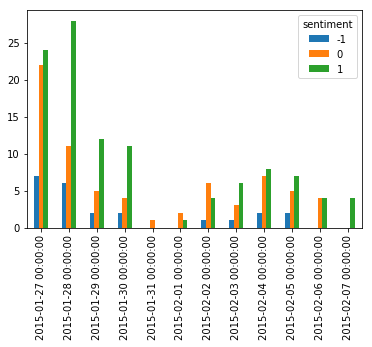

In [25]:
twitterData.groupby(twitterData.index).sentiment.value_counts().head(30).unstack().plot.bar()
#plotting ddaily sentiment amounts for first 10 days

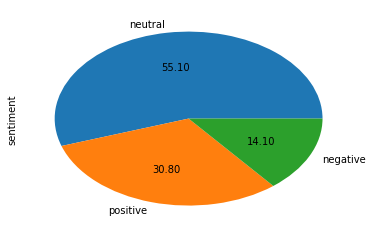

In [26]:
twitterData.sentiment.value_counts().plot.pie(labels=['neutral','positive','negative'],autopct='%.2f')
#showing sentimennt percents for whole dataframe

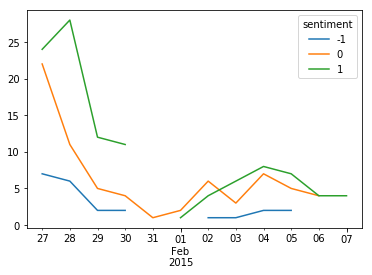

In [27]:
twitterData.groupby(twitterData.index).sentiment.value_counts().head(30).unstack().plot()
#plotting line graph of sentiments by day

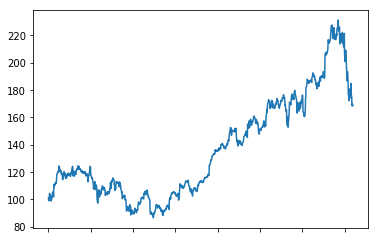

In [28]:
Stock.close.plot()
plt.show()
#closing prices of the stock plotted

In [29]:
twitterData.sort_index()#sorting index by date
twitterData.head()

,body,date,sentiment,predNum,prediction,price,pricePCTch,Change
2015-01-27,apple reports eps vs est sales vs est aapl,2015-01-27T21:30:28.000Z,0,-0.176902,0,101.7863,-0.035013,-1
2015-01-27,aapl has not seen price like this since yester...,2015-01-27T21:43:08.000Z,-1,-0.412915,0,101.7863,-0.035013,-1
2015-01-27,aapl in the morning thats my best guess,2015-01-27T21:41:26.000Z,1,0.486429,4,101.7863,-0.035013,-1
2015-01-27,in fy aapl annual revenue was aapl quarterly r...,2015-01-27T23:01:39.000Z,-1,-0.473401,0,101.7863,-0.035013,-1
2015-01-27,and the aapl earnings gamblers assume the posi...,2015-01-27T21:03:16.000Z,1,0.484767,4,101.7863,-0.035013,-1


In [30]:
twitterData.sentiment.value_counts()

 1    6527
 0    3648
-1    1670
Name: sentiment, dtype: int64

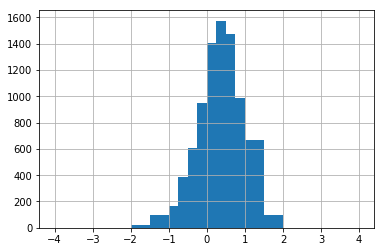

In [31]:
twitterData.groupby(twitterData.index).head(10).predNum.hist(bins=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4])
# HISTOGRAM OF SENTIMENT
#use histogram to predict  price by each bin being a feature

In [32]:
binSize= pd.DataFrame(twitterData.groupby(twitterData.index).predNum.value_counts(bins=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,2.5,3,3.5,4], sort=False))
#placing each days bins in a dataframe

In [33]:
#Server=tcp:feels.database.windows.net,1433;Initial Catalog=twitter;Persist Security Info=False;User ID=NYIT;Password=Pineapple!;MultipleActiveResultSets=False;Encrypt=True;TrustServerCertificate=False;Connection Timeout=30;

In [34]:
binSize.columns = ['predNumAmmount']#renaming columns to predNumAmmount

In [35]:
newBin = pd.DataFrame(binSize['predNumAmmount'])
newBin = newBin.reset_index()
newBin = newBin.pivot(index='level_0', columns='predNum', values='predNumAmmount')
#reset index and pivot dataframe to make it easier to work with

In [36]:
newBin.sort_index()
newBin.index.name = None
newBin.columns.name = None
newBin.columns = ['(-4.001, -3.5]','(-3.5, -3.0]','(-3.0, -2.5]','(-2.5, -2.0',
                '(-2.0, -1.5]','(-1.5, -1.0]','(-1.0, -0.75]','(-0.75, -0.5]','(-0.5, -0.25]',
                                   '(-0.25, 0.0]','(0.0, 0.25]','(0.25, 0.5]','(0.5, 0.75]','(0.75, 1.0]','(1.0, 1.5]',
                                   '(1.5, 2.0]','(2.0, 2.5]','(2.5, 3.0]','(3.0, 3.5]','(3.5, 4.0]']
#renaming the columns and cleaning the dataframe

In [37]:
twitterDataMean = twitterData.groupby(twitterData.index).mean()
#creates a dataframe of the mean values of twitterData

In [38]:
twitterDataMax =  twitterData.groupby(twitterData.index).max()
#creates a dataframe of the max values of twitterData

In [39]:
twitterDataMin =  twitterData.groupby(twitterData.index).min()
#creates a dataframe of the min values of twitterData

In [40]:
twitterDataMedian =  twitterData.groupby(twitterData.index).median()
#creates a dataframe of the median values of twitterData

In [41]:
twitterData['averageSentiment']= twitterDataMean['predNum']
#creates new column in twitterData dataframe using twitterData mean value of predNum

In [42]:
twitterData = twitterData.merge(newBin,left_index=True, right_index=True)
#merge twitterData with newBin dataframe

In [43]:
twitterDataMean= twitterDataMean.merge(newBin,left_index=True, right_index=True)
twitterDataMean['maxPred'] = twitterDataMax['predNum']
twitterDataMean['minPred'] = twitterDataMin['predNum']
twitterDataMean['range'] = twitterDataMax['predNum']-twitterDataMin['predNum']
twitterDataMean['STD'] = twitterData.groupby(twitterData.index).predNum.std().fillna(method='ffill')
#create new columns in twitterDataMean for features

In [44]:
twitterData['maxPred'] = twitterDataMax['predNum']
twitterData['minPred'] = twitterDataMin['predNum']
twitterData['range'] = twitterDataMax['predNum']-twitterDataMin['predNum']
twitterData['STD'] = twitterData.groupby(twitterData.index).predNum.std().fillna(method='ffill')
#puts new columnss in twitterData dataframe

In [45]:
twitterDataMean['Change'].value_counts()

 0.0    1151
-1.0      96
 1.0      88
Name: Change, dtype: int64

In [46]:
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.9, random_state = 1).index)
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == -1.0').sample(frac=.05,random_state = 1).index)
# twitterDataMean = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.87,random_state = 1).index)

In [47]:
twitterDataMean['Change'].value_counts()

 0.0    1151
-1.0      96
 1.0      88
Name: Change, dtype: int64

In [48]:
# twitterDataMean

In [49]:
featureCols = ['(-4.001, -3.5]','(-3.5, -3.0]','(-3.0, -2.5]','(-2.5, -2.0',
                '(-2.0, -1.5]','(-1.5, -1.0]','(-1.0, -0.75]','(-0.75, -0.5]','(-0.5, -0.25]',
                                   '(-0.25, 0.0]','(0.0, 0.25]','(0.25, 0.5]','(0.5, 0.75]','(0.75, 1.0]','(1.0, 1.5]',
                                   '(1.5, 2.0]','(2.0, 2.5]','(2.5, 3.0]','(3.0, 3.5]','(3.5, 4.0]','predNum','maxPred','minPred','range','STD']
#features to be selected

In [50]:
X = twitterDataMean[featureCols]#features to be used by model
y = twitterDataMean['Change']#target values
twit = twitterDataMean
acc = 0
ran = 0
drop_ran = 0

for x in range(1,20):
    twitterDataMean = twit
    y = twitterDataMean.drop(twitterDataMean.query('Change == 0').sample(frac=.9, random_state=x).index)

    for xx in range(1,100):
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=xx)
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression().fit(X_train2,y_train2)
        y_pred3 = clf.predict(X_test2)
        #implementing logistic regression moddel with confusion matrix and other measures  
        from sklearn.model_selection import cross_val_score  
        accuracies1 = cross_val_score(estimator = clf, X = X_train2, y = y_train2, cv = 5)
        if accuracies1.mean() > acc:
            acc = accuracies1.mean()
            mod = 'Logistic Regression'
            ran = xx
            drop_ran = x

        from sklearn.ensemble import RandomForestClassifier
        model=RandomForestClassifier()
        model.fit(X_train2,y_train2)
        y_pred4 = model.predict(X_test2)
        #implementing RandomForestClassifier moddel with confusion matrix and other measures
        from sklearn.model_selection import cross_val_score  
        accuracies2 = cross_val_score(estimator = model, X = X_train2, y = y_train2, cv = 5)
        if accuracies2.mean() > acc:
            acc = accuracies2.mean()
            mod = 'Random Forest Classifier'
            ran = xx
            drop_ran = x

        from sklearn import tree
        tree = tree.DecisionTreeClassifier()
        tree = tree.fit(X_train2,y_train2)
        y_pred5 = tree.predict(X_test2)
        # implementing decision tree moddel with confusion matrix and other measures
        from sklearn.model_selection import cross_val_score  
        accuracies3 = cross_val_score(estimator = tree, X = X_train2, y = y_train2, cv = 5)
        if accuracies3.mean() > acc:
            acc = accuracies3.mean()
            mod = 'Decision Tree'
            ran = xx
            drop_ran = x

        from sklearn.svm import SVC
        svm = SVC()
        svm.fit(X_train2, y_train2)
        y_pred2 = svm.predict(X_test2) 
        from sklearn.model_selection import cross_val_score  
        accuracies4 = cross_val_score(estimator = svm, X = X_train2, y = y_train2, cv = 5)
        if accuracies4.mean() > acc:
            acc = accuracies4.mean()
            mod = 'SVM'
            ran = xx
            drop_ran = x

print('Model: ', mod)
print('CV: ', acc)
print('Random: ', ran)
print('Random Drop: ', drop_ran)

ValueError: Found input variables with inconsistent numbers of samples: [1335, 299]

In [ ]:
X2 = twitterDataMean[featureCols]#features to be used by model
y2 = twitterDataMean['Change']#target values


X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=60)
#splitting into train and test
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

In [ ]:
twitterDataMean['Change'].value_counts()

In [ ]:
X.head()

In [ ]:
X_train2.sort_index()
X_train2.head()

In [ ]:
y_train2.head()

In [ ]:
y_test2.head()

In [ ]:
X_test2.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train2,y_train2)
y_pred3 = clf.predict(X_test2)
#implementing logistic regression moddel with confusion matrix and other measures
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test2,y_pred3))  
print(classification_report(y_test2,y_pred3))  

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred3)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Negative' , 'Neutral', 'Positive'], 
                     columns = ['Negative' , 'Neutral', 'Positive'])
plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Logistic Regression')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [ ]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = clf, X = X_train2, y = y_train2, cv = 5)
accuracies.mean()
#cross validation accuracy score

In [ ]:
plt.scatter(y_test2, y_pred3)
plt.xlabel('Price')
plt.ylabel('Predicted Prices')
plt.title('Prices vs Predicted Prices')
plt.gcf().autofmt_xdate()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
model.fit(X_train2,y_train2)
y_pred4 = model.predict(X_test2)
#implementing RandomForestClassifier moddel with confusion matrix and other measures
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test2,y_pred4))  
print(classification_report(y_test2,y_pred4))  

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred4)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Negative' , 'Neutral', 'Positive'], 
                     columns = ['Negative' , 'Neutral', 'Positive'])

plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Random Forest Classifier')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [ ]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = model, X = X_train2, y = y_train2, cv = 5)
accuracies.mean()

In [ ]:
feature = model.feature_importances_
plt.bar(range(len(feature)), feature, align='center')
plt.xticks(range(len(feature)), featureCols, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()
#shows on bar graph all features and which is the most important

In [ ]:
plt.scatter(y_test2, y_pred4)
plt.xlabel('Price')
plt.ylabel('Predicted Prices')
plt.title('Prices vs Predicted Prices')
plt.gcf().autofmt_xdate()

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_train2,y_train2)
y_pred5 = tree.predict(X_test2)
#implementing decision tree moddel with confusion matrix and other measures

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test2,y_pred5))  
print(classification_report(y_test2,y_pred5))  

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred5)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Negative' , 'Neutral', 'Positive'], 
                     columns = ['Negative' , 'Neutral', 'Positive'])
plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('Decision Tree')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [ ]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = tree, X = X_train2, y = y_train2, cv = 5)
accuracies.mean()

In [ ]:
feature2 = tree.feature_importances_
plt.bar(range(len(feature2)), feature2, align='center')
plt.xticks(range(len(feature2)), featureCols, rotation='vertical')
plt.title('Feature importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()
#shows on bar graph all features and which is the most important

In [ ]:
plt.scatter(y_test2, y_pred5)
plt.xlabel('Price')
plt.ylabel('Predicted Prices')
plt.title('Prices vs Predicted Prices')
plt.gcf().autofmt_xdate()

In [ ]:
from sklearn.svm import SVC
svm= SVC()
#import of svm model with rbf kernel

In [ ]:
%%time
svm.fit(X_train2, y_train2)

In [ ]:
from sklearn.model_selection import cross_val_score  
accuracies = cross_val_score(estimator = svm, X = X_train2, y = y_train2, cv = 5)
accuracies.mean()

In [ ]:
y_pred2 = svm.predict(X_test2)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test2,y_pred2))  
print(classification_report(y_test2,y_pred2))  
#classiication report and confussion matrix

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2,y_pred2)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index = ['Negative' , 'Neutral', 'Positive'], 
                     columns = ['Negative' , 'Neutral', 'Positive'])

plt.figure(figsize = (5,4))
graph = sn.heatmap(df_cm, annot=True)
graph.set_title('SVM')
graph.set_ylabel('True label')
graph.set_xlabel('Predicted label')
#Plotting of the confusion matrix

In [ ]:
plt.scatter(y_test2, y_pred2)
plt.xlabel('Price')
plt.ylabel('Predicted Prices')
plt.title('Prices vs Predicted Prices')
plt.gcf().autofmt_xdate()

In [ ]:
plt.plot(y_test2, y_pred2, color='blue') 
plt.show()